In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement

In [8]:
# Create a session
session = Session(engine)

In [9]:
# EXTRA # Day 2 Ex 05 -Ins_Reflection
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237dde9b820>,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 18.3,
 'id': 0,
 'prcp': 2.0}

In [10]:
# EXTRA  # Day 2 Ex 07-Ins_Inspection and also Day 2 Ex 08-Stu_Salary_Exploration  Printed 08 only
from sqlalchemy import create_engine, inspect
 # Create the inspector and connect it to the engine
inspector = inspect(engine)
 # Collect the names of tables within the database
inspector.get_table_names()
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [12]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print ("Query Date:", query_date)

Query Date: 2016-08-23


In [13]:
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()
#session.query(Measurement.date, Measurement.prcp).\
print (precipitation)

[('2016-08-23', 0.0), ('2016-08-24', 2.0), ('2016-08-25', 2.0), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.3), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 3.3), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.8), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 1.3), ('2016-09-08', 0.0), ('2016-09-09', 0.8), ('2016-09-10', 0.0), ('2016-09-11', 1.3), ('2016-09-12', 0.0), ('2016-09-13', 0.5), ('2016-09-14', 33.5), ('2016-09-15', 10.7), ('2016-09-16', 1.5), ('2016-09-17', 1.3), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.5), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 1.5), ('2016-09-27', 0.5), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 0.0), ('2016-1

Query Date: 2016-08-23


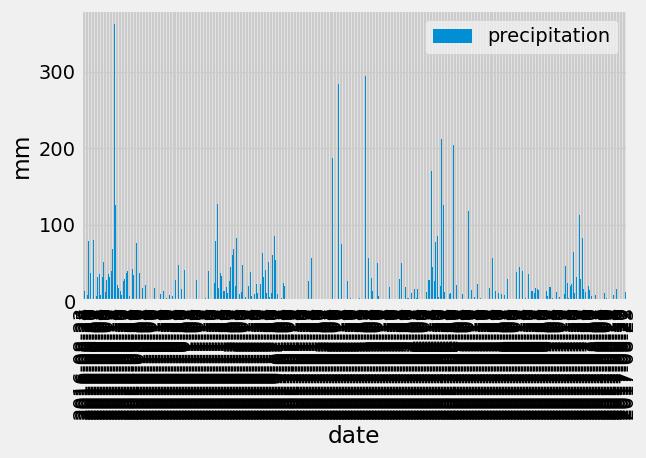

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print ("Query Date:", query_date)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date','precipitation'])
precipitation_df.count()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')
precipitation_df.head(50)

precipitation_groupby_obj = precipitation_df.groupby('date')

precipitation_series = precipitation_groupby_obj['precipitation'].sum()

precipitation_plot_df = pd.DataFrame(precipitation_series)
# precipitation_plot_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_plot_df.plot.bar()
precipitation_df.set_index('date', inplace=True)
plt.tight_layout()
plt.ylabel("mm")
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = precipitation_df.count()
mean = precipitation_df['precipitation'].mean()
std = precipitation_df['precipitation'].std()
min = precipitation_df['precipitation'].min()
max = precipitation_df['precipitation'].max()

# Reference: https://www.aporia.com/blog/how-to/convert-index-dataframe-to-column/
quartiles = precipitation_df.quantile([.25, .5, .75])
quartiles = quartiles.reset_index().rename(columns={"index":"quartile"})
# Reference: https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-in-pandas
lowerq = quartiles.loc[quartiles['quartile'] == 0.25, 'precipitation'].iloc[0]
middleq = quartiles.loc[quartiles['quartile'] == 0.50, 'precipitation'].iloc[0]
upperq = quartiles.loc[quartiles['quartile'] == 0.75, 'precipitation'].iloc[0]

# Create a DataFrame for summary statistics
summary_statistics_df = pd.DataFrame({
    "count": count,
    "mean": mean,
    "std": std,
    "min": min,
    "25%": lowerq,
    "50%": middleq,
    "75%": upperq,   
    "max": max    
})
summary_statistics_df.transpose()

#Reference: https://www.geeksforgeeks.org/python-pandas-dataframe-transpose/



,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset    # Answer = 9
station_count = session.query(Measurement).group_by(Measurement.station).count()
print(station_count)

9


In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(12.2, 29.4, 22.03582251082252)]

Text(0.5, 4.183333333333314, 'Temperature')

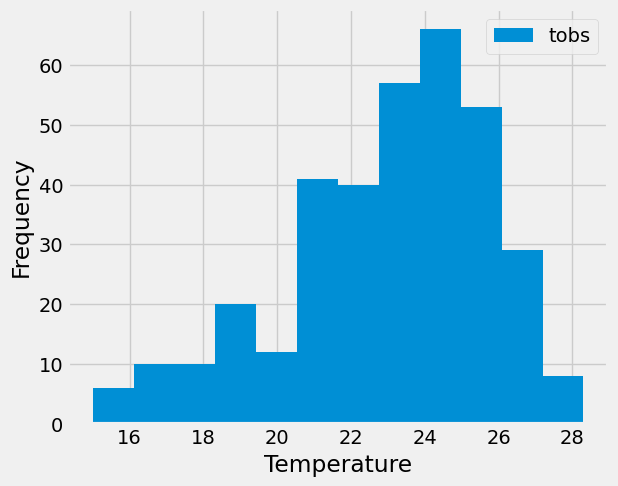

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()
